In [ ]:
import util%
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from os.path import join as pj
from os.path import split as ps
from tifffile import imread
from skimage.restoration import denoise_nl_means, estimate_sigma
from csbdeep.data import Normalizer, PercentileNormalizer

%matplotlib inline

from glob import glob

import re

# Tables

## Consolidate summary csvs

In [157]:
def consolidate_tables(ddir, outfile):
    df_ls = [pd.read_csv(f) for f in glob(pj(ddir, '*summary.csv'))]
    df_ls = [pd.concat(df_ls, ignore_index=True).drop_duplicates()]
    df_ls.append(df_ls.append(pd.read_csv(pj(ddir, 'paper_results.csv'))))

    for df, x in zip(df_ls, ['replication', 'original']):
        df['study'] = x 

    df = pd.concat(df_ls,  sort=True)
    # drop the dates form model names
    df['output'] = [re.split('\d{4}-\d{2}-\d{2}-', o)[-1] for o in df['output']]
    df.to_csv(outfile, index=False, float_format='%.5f')


outs = ['tables/planaria_test_data_summary.csv', 'tables/beetle_test_data_summary.csv']
ddirs = ['planaria_results', 'beetle_results']

for ddir, out in zip(ddirs, outs):
    consolidate_tables(ddir, out)


## Cosolidate raw csvs

In [128]:
def consolidate_tables(ddir, outfile):
    df_ls = [pd.read_csv(f) for f in glob(pj(ddir, '*raw.csv'))]
    df_ls = [pd.concat(df_ls, ignore_index=True).drop_duplicates()]
#     df_ls.append(df_ls.append(pd.read_csv(pj(ddir, 'paper_results.csv'))))

    for df, x in zip(df_ls, ['replication', 'original']):
        df['study'] = x 

    df = pd.concat(df_ls,  sort=True)
    # drop the dates form model names
    df['output'] = [re.split('\d{4}-\d{2}-\d{2}-', o)[-1] for o in df['output']]
    df.to_csv(outfile, index=False)


outs = ['tables/planaria_test_data_raw.csv', 'tables/beetle_test_data_raw.csv']
ddirs = ['planaria_results', 'beetle_results']

for ddir, out in zip(ddirs, outs):
    consolidate_tables(ddir, out)


## Write RMSE and SSIM wide tables

In [169]:
def _write_wide_tables(df, table_out):
    df = df.drop('std', axis=1)
    df = pd.pivot_table(df, columns=['metric', 'output'], index='condition')

    df.columns = df.columns.droplevel()
    display(df.head())
    df.to_csv(table_out)
    
long = ['tables/planaria_test_data_summary.csv', 'tables/beetle_test_data_summary.csv']
df_ls = [pd.read_csv(f) for f in long]
wide = ['tables/planaria_wide.csv', 'tables/beetle_wide.csv']

for df, name in zip(df_ls, wide):
    _write_wide_tables(df, name)


metric          rmse                                                        \
output      beetle-1    input     nlm paper_input paper_network planaria-1   
condition                                                                    
condition_1  0.06538  0.21048  0.1766     0.08384       0.03768    0.02868   
condition_2  0.07716  0.26055     NaN     0.08818       0.03942    0.03607   
condition_3  0.28242  0.34852     NaN     0.09103       0.04780    0.05468   

metric                                ssim                                \
output      planaria-3 planaria-4 beetle-1    input      nlm paper_input   
condition                                                                  
condition_1    0.02895    0.03184  0.60107  0.11773  0.29578     0.21176   
condition_2    0.03662    0.03661  0.50297  0.08548      NaN     0.17071   
condition_3    0.05514    0.05828  0.12025  0.05303      NaN     0.14415   

metric                                                      
output      paper_network planaria-1 planaria-3 planaria-4  
condition                                                   
condition_1       0.70774    0.90556    0.90007    0.87298  
condition_2       0.70803    0.84428    0.87815    0.86077  
condition_3       0.60972    0.65758    0.68133    0.65351

metric          rmse                                                       \
output      beetle-1 beetle-2    input      nlm paper_input paper_network   
condition                                                                   
condition_1  0.15899  0.16962  0.15922  0.15954     0.09556       0.03301   
condition_2  0.12944  0.13844  0.12552  0.12686     0.08910       0.02751   
condition_3  0.10228  0.10889  0.09226  0.09500     0.07629       0.02356   

metric                                           ssim                    \
output      planaria-1 planaria-3 planaria-4 beetle-1 beetle-2    input   
condition                                                                 
condition_1    0.15237    0.15351    0.14287  0.16884  0.06984  0.07715   
condition_2    0.11953    0.12155    0.11140  0.29160  0.11991  0.12712   
condition_3    0.08833    0.09206    0.08269  0.50745  0.23032  0.23385   

metric                                                                \
output           nlm paper_input paper_network planaria-1 planaria-3   
condition                                                              
condition_1  0.08183     0.17048       0.88278    0.11063    0.10311   
condition_2  0.13428     0.22931       0.90670    0.19436    0.18280   
condition_3  0.24528     0.36174       0.92217    0.36839    0.34747   

metric                  
output      planaria-4  
condition               
condition_1    0.15098  
condition_2    0.25372  
condition_3    0.44856

In [104]:
df_ls = [pd.read_csv(f) for f in ['tables/planaria_test_data_summary.csv',
                                  'tables/beetle_test_data_summary.csv']]
df = df_ls[0]
df = df.drop('std', axis=1)

outputs = ['planaria-1', 'planaria-3']
_outputs = ['input'] + outputs + ['paper_input', 'paper_network']

df = df[df['output'].isin(_outputs)]

df = pd.pivot_table(df, columns=['metric', 'output'], index='condition')
df.columns = df.columns.droplevel()
df.head()


metric          rmse                                                     ssim  \
output         input paper_input paper_network planaria-1 planaria-3    input   
condition                                                                       
condition_1  0.21048     0.08384       0.03768    0.02868    0.02895  0.11773   
condition_2  0.26055     0.08818       0.03942    0.03607    0.03662  0.08548   
condition_3  0.34852     0.09103       0.04780    0.05468    0.05514  0.05303   

metric                                                       
output      paper_input paper_network planaria-1 planaria-3  
condition                                                    
condition_1     0.21176       0.70774    0.90556    0.90007  
condition_2     0.17071       0.70803    0.84428    0.87815  
condition_3     0.14415       0.60972    0.65758    0.68133

# Plots

## Graphs

In [106]:
df_ls = [pd.read_csv(f) for f in ['tables/planaria_test_data_summary.csv',
                                  'tables/beetle_test_data_summary.csv']]
df = df_ls[0]
df.head()

,condition,mean,metric,output,std,study
0,condition_1,0.06538,rmse,beetle-1,0.01124,replication
1,condition_1,0.60107,ssim,beetle-1,0.06290,replication
2,condition_1,0.17660,rmse,nlm,0.04909,replication
3,condition_1,0.29578,ssim,nlm,0.12494,replication
4,condition_1,0.02868,rmse,planaria-1,0.00553,replication


## Using summary

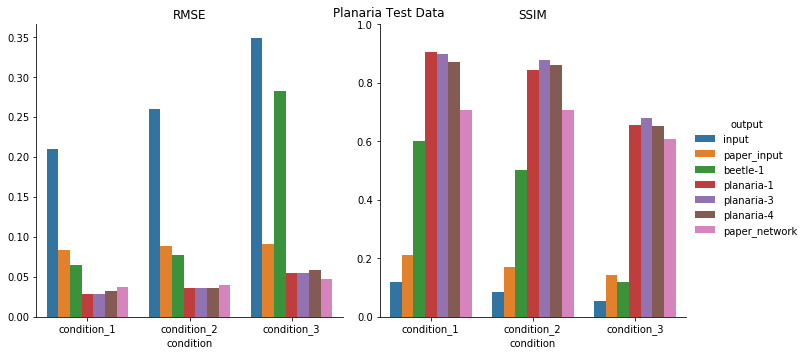

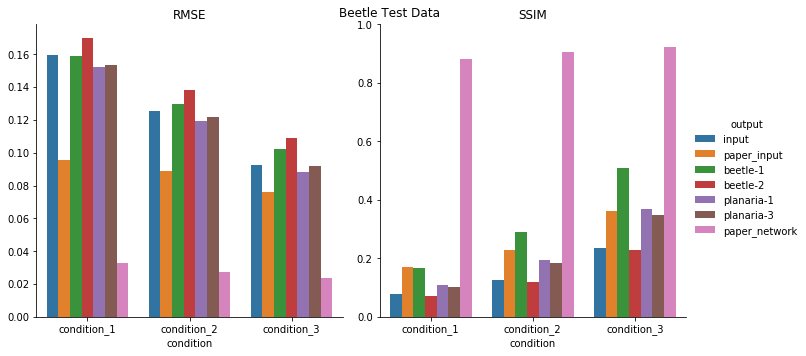

In [155]:
df_ls = [pd.read_csv(f) for f in ['tables/planaria_test_data_summary.csv',
                                  'tables/beetle_test_data_summary.csv']]
no = ['planaria-4']

df_ls[1] = df_ls[1][~df_ls[1]['output'].isin(no)]
# df_ls[1] = [df_ls[[~df['output'].isin(no)] for df in df_ls]

            
for df, name in zip(df_ls, ['Planaria Test Data', 'Beetle Test Data']):
    cols = df['output'].unique()
    pop = ['input', 'paper_input']
    cols = [x for x in sorted(cols) if x not in pop + ['nlm', 'paper_network']]
    cols = pop + cols + ['paper_network']


    g = sns.catplot(x='condition', y='mean', hue='output', 
                    kind='bar',
                    col='metric',
                    hue_order=cols,
                    sharey=False, data=df)
    
    g.axes[0,1].set_ylim(0,1)
    g.set_ylabels('')
    g.axes[0,0].set_title('RMSE')
    g.axes[0,1].set_title('SSIM')
    g.fig.suptitle(name)

## Using raw
I.e., variance so we can do boxplots

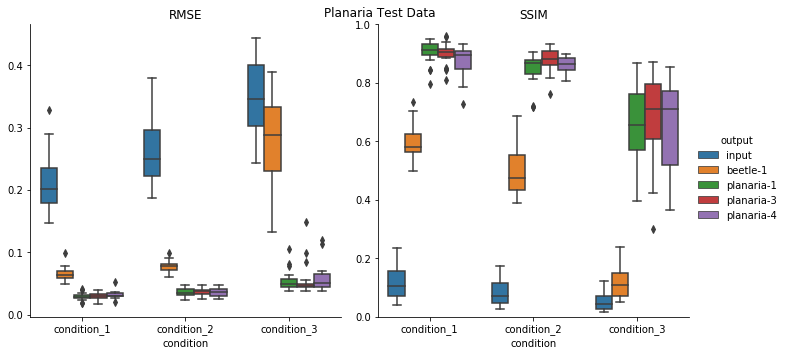

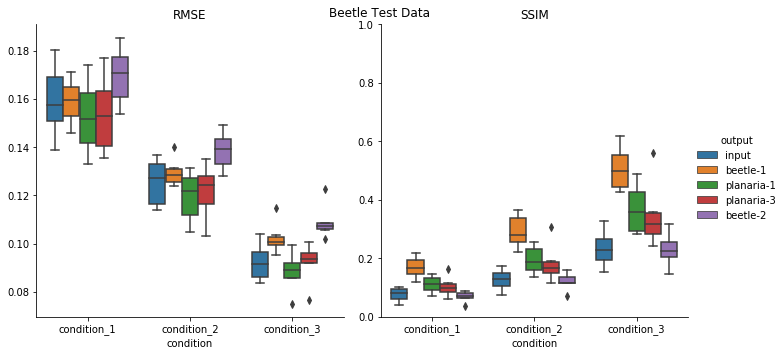

In [154]:
df_ls = [pd.read_csv(f) for f in ['tables/planaria_test_data_raw.csv',
                                  'tables/beetle_test_data_raw.csv']]
df_ls[1] = df_ls[1][~df_ls[1]['output'].isin(no)]

for df, name in zip(df_ls, ['Planaria Test Data', 'Beetle Test Data']):

    cols = df['output'].unique()
    pop = ['input', 'beetle-1', 'planaria-1']
    cols = [x for x in cols if x not in pop + ['nlm']]
    cols = pop + cols


    g = sns.catplot(x='condition', y='value', hue='output', 
                    kind='box',
                    col='metric',
                    hue_order=cols,
                    sharey=False, data=df)
    g.axes[0,1].set_ylim(0,1)
    g.set_ylabels('')
    g.axes[0,0].set_title('RMSE')
    g.axes[0,1].set_title('SSIM')
    g.fig.suptitle(name)